## Visualize country admin1 country level results

In this notebook we quickly plot the some resulting maps from the model putput for the Phillippines, Madagaskar and Japan.

Shapefiles for the counrty/admin1 boarders can be accessed here: https://gadm.org/download_country.html

For single countries it's enough to download shapefiles of the respective countries. However, the same logic also works when using the global file containing all boarders (it just becomes quite slow & data intensive).

In [1]:
# load libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
from cartopy import crs as ccrs
import seaborn as sns
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# paths (to be adjusted when running on different machines)
tc_risk_path = '/Users/sam/Library/CloudStorage/OneDrive-ETHZurich/UNU/Data/Results/risk_tc/'
cf_risk_path = '/Users/sam/Library/CloudStorage/OneDrive-ETHZurich/UNU/Data/Results/risk_cf/'
# this file is important for switching between admin1 naming conventions
admin1_lookup = pd.read_csv('/Users/sam/Library/CloudStorage/OneDrive-ETHZurich/UNU/Data/Results/Shapefiles/attribute_table_gadm41.csv')
shp_path = '/Users/sam/Library/CloudStorage/OneDrive-ETHZurich/UNU/Data/Results/Shapefiles/'
fig_save_path ='/Users/sam/Library/CloudStorage/OneDrive-ETHZurich/UNU/Data/Results/UR_plots/'

# projection for plotting
robinson = ccrs.Robinson().proj4_init

In [3]:
#%% # functions for preparing the geopandas dataframes for TC and CF risk
def prep_gpd_df_values(gpd_df_cntry, ccode, tc_risk_path, rcp, thresh, rp, year):
    ''' Prepares the geopandas dataframe with the values from the TC risk csv file'''

    tc_vals = pd.read_csv(f'{tc_risk_path}/{ccode}/{ccode}_ssp{rcp}_{thresh}_TC.csv', index_col=0)
    tc_vals = tc_vals[tc_vals['Period'] == year]
    tc_vals = tc_vals[tc_vals['Exposure'] != 'admin0']
    tc_vals['Exposure'] = tc_vals['Exposure'].str.replace('admin1_', '')
    tc_vals['Exposure'] = tc_vals['Exposure'].astype(float).astype(int)
    tc_vals.rename(columns={'Exposure': 'fid'}, inplace=True)
    tc_vals = tc_vals.merge(cntry_admin1[['fid', 'GID_1']], on='fid')
    gpd_df_cntry = gpd_df_cntry.merge(tc_vals[['GID_1', rp]], on='GID_1')
    gpd_df_cntry.rename(columns={rp: rp+'_'+rcp+'_'+year}, inplace=True)

    return gpd_df_cntry

def cf_prep_gpd_df_values(gpd_df_cntry, ccode, cf_risk_path, rcp, thresh,
                          rp, year, impf_source='cima'):
    ''' Prepares the geopandas dataframe with the values from the cd risk csv file'''

    cf_vals = pd.read_csv(f'{cf_risk_path}{ccode}/{ccode}_{rcp}_{year}_{impf_source}.csv')
    cf_vals = cf_vals[cf_vals['admin1'] != 'admin0']
    cf_vals['admin1'] = cf_vals['admin1'].astype(float).astype(int)
    cf_vals.rename(columns={'admin1': 'fid'}, inplace=True)
    cf_vals = cf_vals[['fid', f'{rp}_{thresh}']]
#    cf_vals = cf_vals.merge(cntry_admin1[['fid', 'GID_1']], on='fid')
    gpd_df_cntry = gpd_df_cntry.merge(cf_vals, on='fid')

    return gpd_df_cntry

## Now comes a ton of plots for PHL & MDG & JPN
These plots where showcased at the understanding risk conference in Japan in June 2024.

Please note the difference in scales. All plots are in robinson projection, and with transparent background.

In [4]:
# load data for PHL
ccode = 'PHL'
cntry_admin1 = admin1_lookup[admin1_lookup['GID_0'] == ccode]
cname = cntry_admin1['COUNTRY'].values[0]

gpd_df_cntry = gpd.read_file(f'{shp_path}gadm41_{ccode}_shp/gadm41_{ccode}_1.shp')
gpd_df_cntry = gpd_df_cntry.merge(cntry_admin1[['fid', 'GID_1']], on='GID_1')

gpd_df_cntry_hist = prep_gpd_df_values(gpd_df_cntry, ccode, tc_risk_path,
                                rcp='245', thresh='0.55', rp='AAD', year='hist')
gpd_df_cntry_2100_245 = prep_gpd_df_values(gpd_df_cntry, ccode, tc_risk_path,
                                rcp='245', thresh='0.55', rp='AAD', year='2100')
gpd_df_cntry_hist_rp250 = prep_gpd_df_values(gpd_df_cntry, ccode, tc_risk_path,
                                rcp='245', thresh='0.55', rp='RP_250', year='hist')
gpd_df_cntry_2100_245_rp250 = prep_gpd_df_values(gpd_df_cntry, ccode, tc_risk_path,
                                rcp='245', thresh='0.55', rp='RP_250', year='2100')


# calc rel change
gpd_df_rel_change = gpd_df_cntry_2100_245.copy()
gpd_df_rel_change['rel_change'] = (gpd_df_cntry_2100_245['AAD_245_2100'] - gpd_df_cntry_hist['AAD_245_hist']) / gpd_df_cntry_hist['AAD_245_hist']
gpd_df_rel_change['rel_change'] = gpd_df_rel_change['rel_change'].replace(np.inf, 10)
gpd_df_rel_change['rel_change'] = gpd_df_rel_change['rel_change'].replace(np.nan, 0)

gpd_df_rel_change_rp250 = gpd_df_cntry_hist_rp250.copy()
gpd_df_rel_change_rp250['rel_change'] = (gpd_df_cntry_2100_245_rp250['RP_250_245_2100'] - gpd_df_cntry_hist_rp250['RP_250_245_hist']) / gpd_df_cntry_hist_rp250['RP_250_245_hist']
gpd_df_rel_change_rp250['rel_change'] = gpd_df_rel_change_rp250['rel_change'].replace(np.inf, 100)
gpd_df_rel_change_rp250['rel_change'] = gpd_df_rel_change_rp250['rel_change'].replace(np.nan, 0)

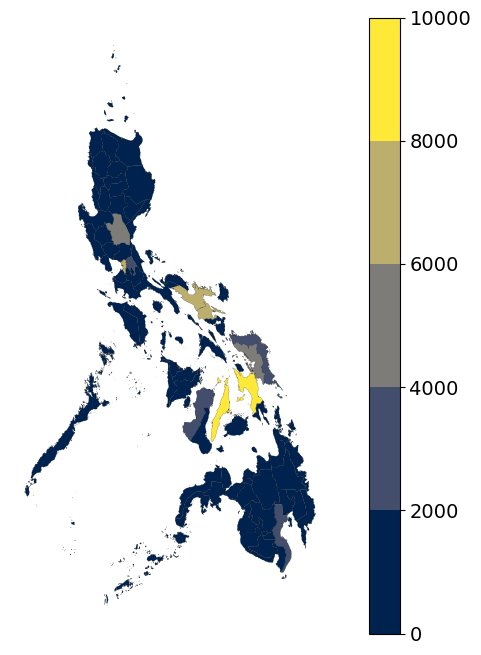

In [5]:
# Plot hist AAD
fontsize = 14
fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('cividis', 5)
gpd_df_cntry_hist.to_crs(robinson).plot(column='AAD_245_hist', ax=ax, legend=True,
                  vmin=0, vmax=10000, cmap=cmap, edgecolor='black', linewidth=0.1)
cbar = ax.get_figure().get_axes()[1]
cbar.set_yticks([0, 2000, 4000, 6000, 8000, 10000])
cbar.tick_params(labelsize=fontsize)
# label title
#ax.set_title('Annual average displaced people - historical', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+f'{ccode}_hist_TC_AAD.png', transparent=True)

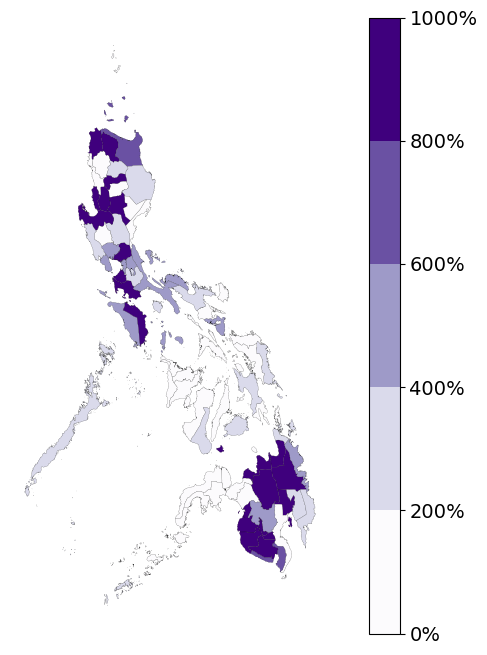

In [6]:
fontsize = 14
fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('Purples', 5)
gpd_df_rel_change.to_crs(robinson).plot(column='rel_change', ax=ax, legend=True,
                  vmin=0, vmax=10, cmap=cmap, edgecolor='black', linewidth=0.1)

cbar = ax.get_figure().get_axes()[1]
#cbar.set_yticks([0, 3000, 6000, 9000, 12000, 15000])
cbar.tick_params(labelsize=fontsize)
# set cbar ticks as percentages
cbar.set_yticklabels([f'{int(i*100)}%' for i in cbar.get_yticks()])
# label title
#ax.set_title('Increase in AA displaced people', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+f'{ccode}_2100_optimistic_rel_change_in_AAD_vs_hist_TC.png', transparent=True)


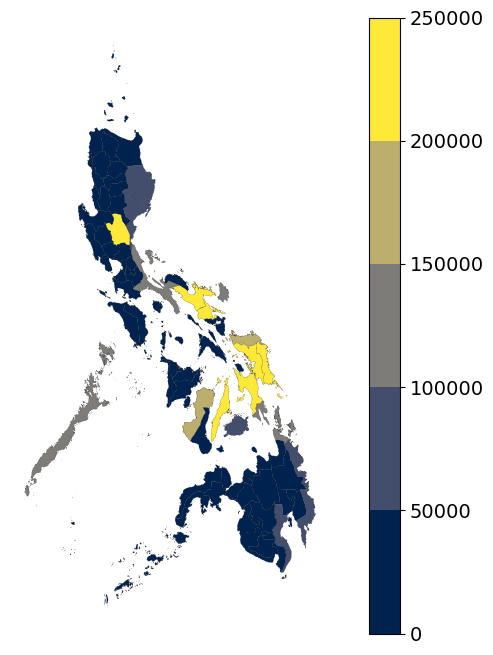

In [7]:
# Plot hist AAD
fontsize = 14
fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('cividis', 5)
gpd_df_cntry_hist_rp250.to_crs(robinson).plot(column='RP_250_245_hist', ax=ax, legend=True,
                  vmin=0, vmax=250000, cmap=cmap, edgecolor='black', linewidth=0.1)
cbar = ax.get_figure().get_axes()[1]
#cbar.set_yticks([0, 2000, 4000, 6000, 8000, 10000])
cbar.tick_params(labelsize=fontsize)
# label title
#ax.set_title('Annual average displaced people - historical', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+f'{ccode}_hist_TC_RP250.png', transparent=True)

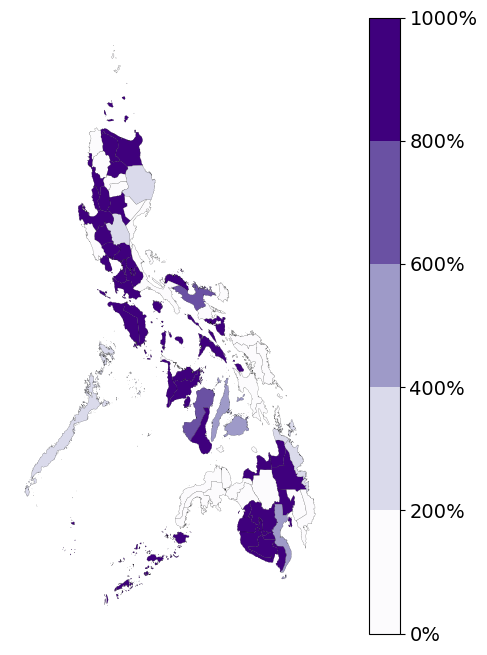

In [8]:
fontsize = 14
fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('Purples', 5)
gpd_df_rel_change_rp250.to_crs(robinson).plot(column='rel_change', ax=ax, legend=True,
                  vmin=0, vmax=10, cmap=cmap, edgecolor='black', linewidth=0.1)

cbar = ax.get_figure().get_axes()[1]
#cbar.set_yticks([0, 3000, 6000, 9000, 12000, 15000])
cbar.tick_params(labelsize=fontsize)
# set cbar ticks as percentages
cbar.set_yticklabels([f'{int(i*100)}%' for i in cbar.get_yticks()])
# label title
#ax.set_title('Increase in AA displaced people', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+f'{ccode}_2100_optimistic_rel_change_in_RP250_vs_hist_TC.png', transparent=True)


## Same for Madagaskar

In [9]:
ccode = 'MDG'
cntry_admin1 = admin1_lookup[admin1_lookup['GID_0'] == ccode]
cname = cntry_admin1['COUNTRY'].values[0]

gpd_df_cntry = gpd.read_file(f'{shp_path}gadm41_{ccode}_shp/gadm41_{ccode}_1.shp')
gpd_df_cntry = gpd_df_cntry.merge(cntry_admin1[['fid', 'GID_1']], on='GID_1')

gpd_df_cntry_hist = prep_gpd_df_values(gpd_df_cntry, ccode, tc_risk_path,
                                rcp='245', thresh='0.55', rp='AAD', year='hist')
gpd_df_cntry_2100_245 = prep_gpd_df_values(gpd_df_cntry, ccode, tc_risk_path,
                                rcp='245', thresh='0.55', rp='AAD', year='2100')
gpd_df_cntry_hist_rp250 = prep_gpd_df_values(gpd_df_cntry, ccode, tc_risk_path,
                                rcp='245', thresh='0.55', rp='RP_250', year='hist')
gpd_df_cntry_2100_245_rp250 = prep_gpd_df_values(gpd_df_cntry, ccode, tc_risk_path,
                                rcp='245', thresh='0.55', rp='RP_250', year='2100')


# calc rel change
gpd_df_rel_change = gpd_df_cntry_2100_245.copy()
gpd_df_rel_change['rel_change'] = (gpd_df_cntry_2100_245['AAD_245_2100'] - gpd_df_cntry_hist['AAD_245_hist']) / gpd_df_cntry_hist['AAD_245_hist']
gpd_df_rel_change['rel_change'] = gpd_df_rel_change['rel_change'].replace(np.inf, 10)
gpd_df_rel_change['rel_change'] = gpd_df_rel_change['rel_change'].replace(np.nan, 0)

gpd_df_rel_change_rp250 = gpd_df_cntry_2100_245_rp250.copy()
gpd_df_rel_change_rp250['rel_change'] = (gpd_df_cntry_2100_245_rp250['RP_250_245_2100'] - gpd_df_cntry_hist_rp250['RP_250_245_hist']) / gpd_df_cntry_hist_rp250['RP_250_245_hist']
gpd_df_rel_change_rp250['rel_change'] = gpd_df_rel_change_rp250['rel_change'].replace(np.inf, 100)
gpd_df_rel_change_rp250['rel_change'] = gpd_df_rel_change_rp250['rel_change'].replace(np.nan, 0)

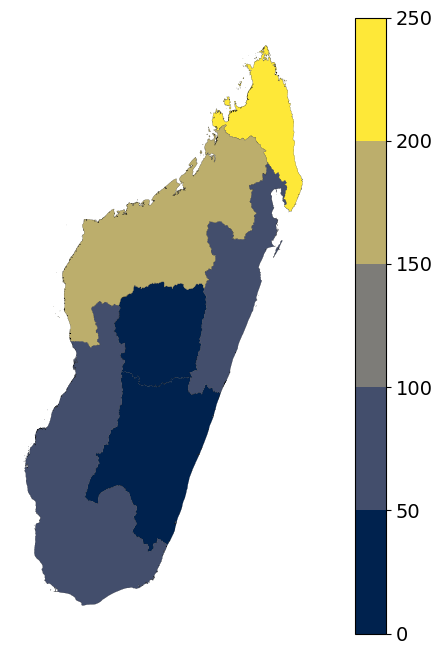

In [10]:
# Plot hist AAD
fontsize = 14
fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('cividis', 5)
gpd_df_cntry_hist.to_crs(robinson).plot(column='AAD_245_hist', ax=ax, legend=True,
                  vmin=0, vmax=250, cmap=cmap, edgecolor='black', linewidth=0.1)
cbar = ax.get_figure().get_axes()[1]
cbar.set_yticks([0, 50, 100, 150, 200, 250])
cbar.tick_params(labelsize=fontsize)
# label title
#ax.set_title('Annual average displaced people - historical', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+f'{ccode}_hist_TC_AAD.png', transparent=True)

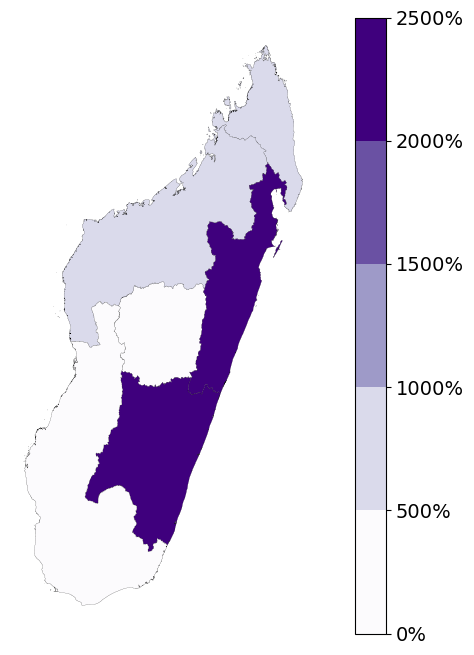

In [11]:
fontsize = 14
fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('Purples', 5)
gpd_df_rel_change.to_crs(robinson).plot(column='rel_change', ax=ax, legend=True,
                  vmin=0, vmax=25, cmap=cmap, edgecolor='black', linewidth=0.1)

cbar = ax.get_figure().get_axes()[1]
#cbar.set_yticks([0, 3000, 6000, 9000, 12000, 15000])
cbar.tick_params(labelsize=fontsize)
# set cbar ticks as percentages
cbar.set_yticklabels([f'{int(i*100)}%' for i in cbar.get_yticks()])
# label title
#ax.set_title('Increase in AA displaced people', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+f'{ccode}_2100_optimistic_rel_change_in_AAD_vs_hist_TC.png', transparent=True)


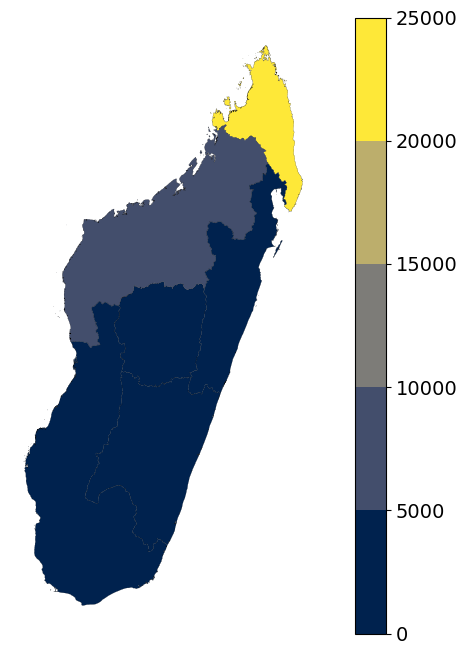

In [12]:
# Plot hist AAD
fontsize = 14
fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('cividis', 5)
gpd_df_cntry_hist_rp250.to_crs(robinson).plot(column='RP_250_245_hist', ax=ax, legend=True,
                  vmin=0, vmax=25000, cmap=cmap, edgecolor='black', linewidth=0.1)
cbar = ax.get_figure().get_axes()[1]
cbar.tick_params(labelsize=fontsize)
# label title
#ax.set_title('Annual average displaced people - historical', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+f'{ccode}_hist_TC_RP250.png', transparent=True)

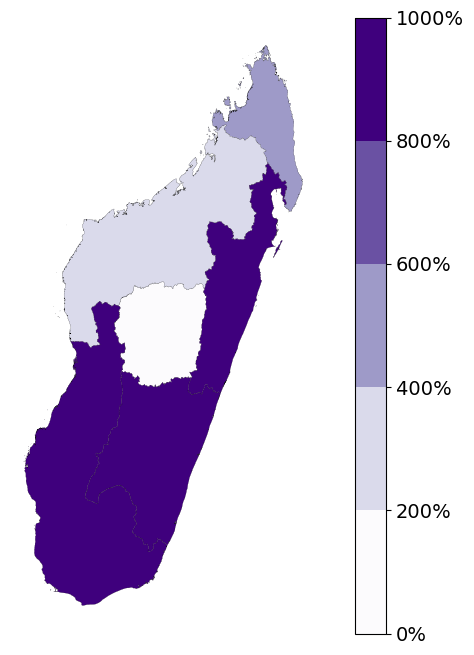

In [13]:
fontsize = 14
fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('Purples', 5)
gpd_df_rel_change_rp250.to_crs(robinson).plot(column='rel_change', ax=ax, legend=True,
                  vmin=0, vmax=10, cmap=cmap, edgecolor='black', linewidth=0.1)

cbar = ax.get_figure().get_axes()[1]
#cbar.set_yticks([0, 3000, 6000, 9000, 12000, 15000])
cbar.tick_params(labelsize=fontsize)
# set cbar ticks as percentages
cbar.set_yticklabels([f'{int(i*100)}%' for i in cbar.get_yticks()])
# label title
#ax.set_title('Increase in AA displaced people', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+f'{ccode}_2100_optimistic_rel_change_in_RP250_vs_hist_TC.png', transparent=True)


## Now the same for coastal flood

In [14]:
ccode = 'PHL'
cntry_admin1 = admin1_lookup[admin1_lookup['GID_0'] == ccode]
cname = cntry_admin1['COUNTRY'].values[0]

gpd_df_cntry = gpd.read_file(f'{shp_path}gadm41_{ccode}_shp/gadm41_{ccode}_1.shp')
gpd_df_cntry = gpd_df_cntry.merge(cntry_admin1[['fid', 'GID_1']], on='GID_1')


gpd_df_cntry_hist = cf_prep_gpd_df_values(gpd_df_cntry, ccode, cf_risk_path,
                                rcp='RCP26', thresh='med', rp='aed', year='2020')
gpd_df_cntry_2100_245 = cf_prep_gpd_df_values(gpd_df_cntry, ccode, cf_risk_path,
                                rcp='RCP26', thresh='med', rp='aed', year='2100')
gpd_df_cntry_hist_rp250 = cf_prep_gpd_df_values(gpd_df_cntry, ccode, cf_risk_path,
                                rcp='RCP26', thresh='med', rp='imp_rp_250.0', year='2020')
gpd_df_cntry_2100_245_rp250 = cf_prep_gpd_df_values(gpd_df_cntry, ccode, cf_risk_path,
                                rcp='RCP26', thresh='med', rp='imp_rp_250.0', year='2100')


# calc rel change
gpd_df_rel_change = gpd_df_cntry_2100_245.copy()
gpd_df_rel_change['rel_change'] = (gpd_df_cntry_2100_245['aed_med'] - gpd_df_cntry_hist['aed_med']) / gpd_df_cntry_hist['aed_med']
gpd_df_rel_change['rel_change'] = gpd_df_rel_change['rel_change'].replace(np.inf, 10)
gpd_df_rel_change['rel_change'] = gpd_df_rel_change['rel_change'].replace(np.nan, 0)

gpd_df_rel_change_rp250 = gpd_df_cntry_2100_245_rp250.copy()
gpd_df_rel_change_rp250['rel_change'] = (gpd_df_cntry_2100_245_rp250['imp_rp_250.0_med'] - gpd_df_cntry_hist_rp250['imp_rp_250.0_med']) / gpd_df_cntry_hist_rp250['imp_rp_250.0_med']
gpd_df_rel_change_rp250['rel_change'] = gpd_df_rel_change_rp250['rel_change'].replace(np.inf, 100)
gpd_df_rel_change_rp250['rel_change'] = gpd_df_rel_change_rp250['rel_change'].replace(np.nan, 0)


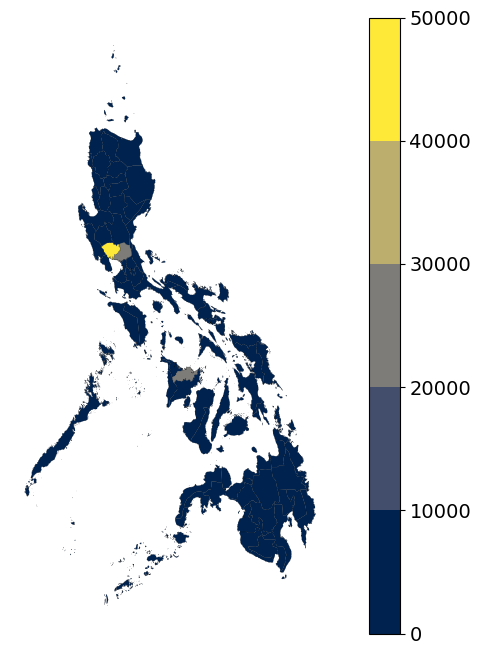

In [15]:

fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('cividis', 5)
gpd_df_cntry_hist.to_crs(robinson).plot(column='aed_med', ax=ax, legend=True,
                  vmin=0, vmax=50000, cmap=cmap, edgecolor='black', linewidth=0.1)
cbar = ax.get_figure().get_axes()[1]
cbar.set_yticks([0, 10000, 20000, 30000, 40000, 50000])
cbar.tick_params(labelsize=fontsize)
# label title
#ax.set_title('Annual average displaced people - historical', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+'PHL_hist_CF_AAD.png', transparent=True)

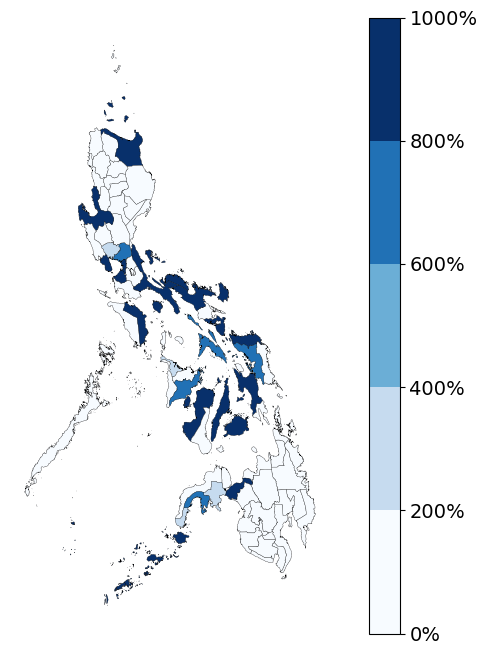

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('Blues', 5)
gpd_df_rel_change.to_crs(robinson).plot(column='rel_change', ax=ax, legend=True,
                  vmin=0, vmax=10, cmap=cmap, edgecolor='black', linewidth=0.2)

cbar = ax.get_figure().get_axes()[1]
#cbar.set_yticks([0, 3000, 6000, 9000, 12000, 15000])
cbar.tick_params(labelsize=fontsize)
# set cbar ticks as percentages
cbar.set_yticklabels([f'{int(i*100)}%' for i in cbar.get_yticks()])
# label title
#ax.set_title('Increase in AA displaced people', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+'PHL_2100_optimistic_rel_change_in_AAD_vs_hist_CF.png', transparent=True)


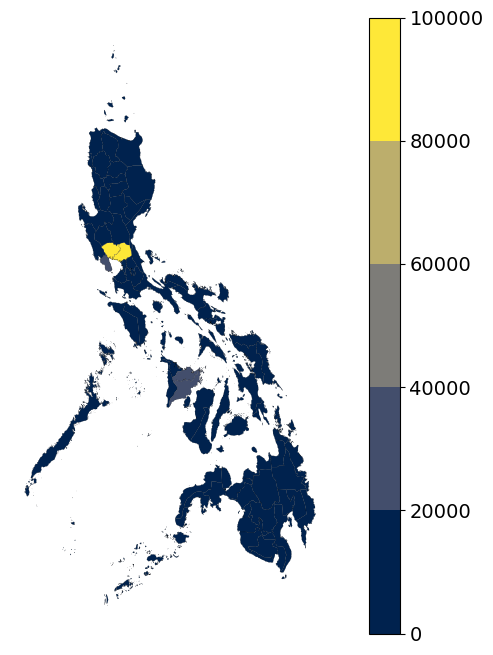

In [17]:

fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('cividis', 5)
gpd_df_cntry_hist_rp250.to_crs(robinson).plot(column='imp_rp_250.0_med', ax=ax, legend=True,
                  vmin=0, vmax=100000, cmap=cmap, edgecolor='black', linewidth=0.1)
cbar = ax.get_figure().get_axes()[1]
#cbar.set_yticks([0, 10000, 20000, 30000, 40000, 50000])
cbar.tick_params(labelsize=fontsize)
# label title
#ax.set_title('Annual average displaced people - historical', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+'PHL_hist_CF_RP250.png', transparent=True)

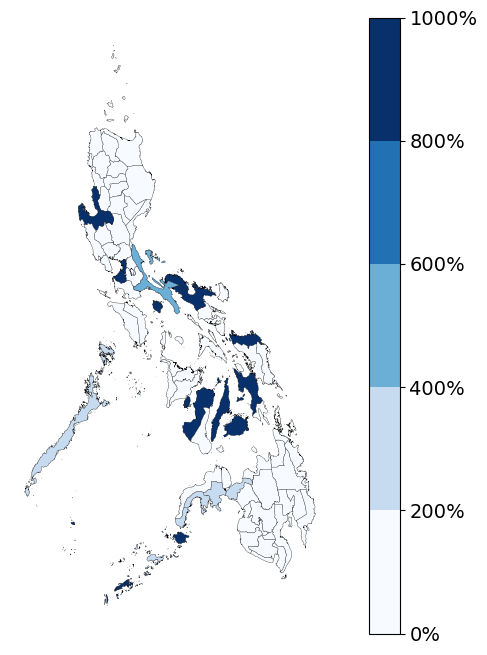

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('Blues', 5)
gpd_df_rel_change_rp250.to_crs(robinson).plot(column='rel_change', ax=ax, legend=True,
                  vmin=0, vmax=10, cmap=cmap, edgecolor='black', linewidth=0.2)

cbar = ax.get_figure().get_axes()[1]
#cbar.set_yticks([0, 3000, 6000, 9000, 12000, 15000])
cbar.tick_params(labelsize=fontsize)
# set cbar ticks as percentages
cbar.set_yticklabels([f'{int(i*100)}%' for i in cbar.get_yticks()])
# label title
#ax.set_title('Increase in AA displaced people', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+'PHL_2100_optimistic_rel_change_in_RP250_vs_hist_CF.png', transparent=True)


## Same for Madagaskar

In [19]:
ccode = 'MDG'
cntry_admin1 = admin1_lookup[admin1_lookup['GID_0'] == ccode]
cname = cntry_admin1['COUNTRY'].values[0]

gpd_df_cntry = gpd.read_file(f'{shp_path}gadm41_{ccode}_shp/gadm41_{ccode}_1.shp')
gpd_df_cntry = gpd_df_cntry.merge(cntry_admin1[['fid', 'GID_1']], on='GID_1')


gpd_df_cntry_hist = cf_prep_gpd_df_values(gpd_df_cntry, ccode, cf_risk_path,
                                rcp='RCP26', thresh='med', rp='aed', year='2020')
gpd_df_cntry_2100_245 = cf_prep_gpd_df_values(gpd_df_cntry, ccode, cf_risk_path,
                                rcp='RCP26', thresh='med', rp='aed', year='2100')
gpd_df_cntry_hist_rp250 = cf_prep_gpd_df_values(gpd_df_cntry, ccode, cf_risk_path,
                                rcp='RCP26', thresh='med', rp='imp_rp_250.0', year='2020')
gpd_df_cntry_2100_245_rp250 = cf_prep_gpd_df_values(gpd_df_cntry, ccode, cf_risk_path,
                                rcp='RCP26', thresh='med', rp='imp_rp_250.0', year='2100')


# calc rel change
gpd_df_rel_change = gpd_df_cntry_2100_245.copy()
gpd_df_rel_change['rel_change'] = (gpd_df_cntry_2100_245['aed_med'] - gpd_df_cntry_hist['aed_med']) / gpd_df_cntry_hist['aed_med']
gpd_df_rel_change['rel_change'] = gpd_df_rel_change['rel_change'].replace(np.inf, 10)
gpd_df_rel_change['rel_change'] = gpd_df_rel_change['rel_change'].replace(np.nan, 0)

gpd_df_rel_change_rp250 = gpd_df_cntry_2100_245_rp250.copy()
gpd_df_rel_change_rp250['rel_change'] = (gpd_df_cntry_2100_245_rp250['imp_rp_250.0_med'] - gpd_df_cntry_hist_rp250['imp_rp_250.0_med']) / gpd_df_cntry_hist_rp250['imp_rp_250.0_med']
gpd_df_rel_change_rp250['rel_change'] = gpd_df_rel_change_rp250['rel_change'].replace(np.inf, 100)
gpd_df_rel_change_rp250['rel_change'] = gpd_df_rel_change_rp250['rel_change'].replace(np.nan, 0)


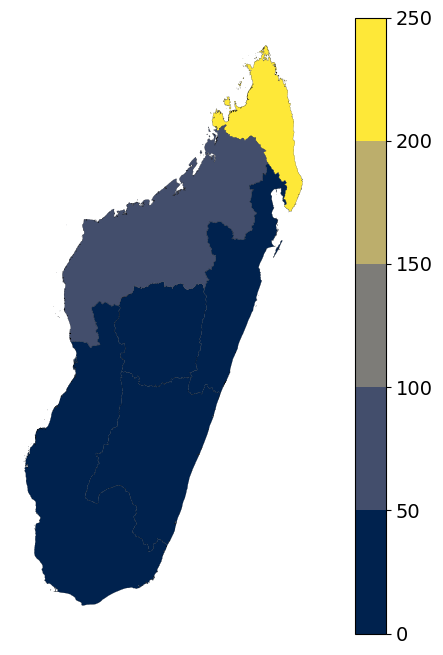

In [20]:

fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('cividis', 5)
gpd_df_cntry_hist.to_crs(robinson).plot(column='aed_med', ax=ax, legend=True,
                  vmin=0, vmax=250, cmap=cmap, edgecolor='black', linewidth=0.1)
cbar = ax.get_figure().get_axes()[1]

cbar.tick_params(labelsize=fontsize)
# label title
#ax.set_title('Annual average displaced people - historical', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+f'{ccode}_hist_CF_AAD.png', transparent=True)

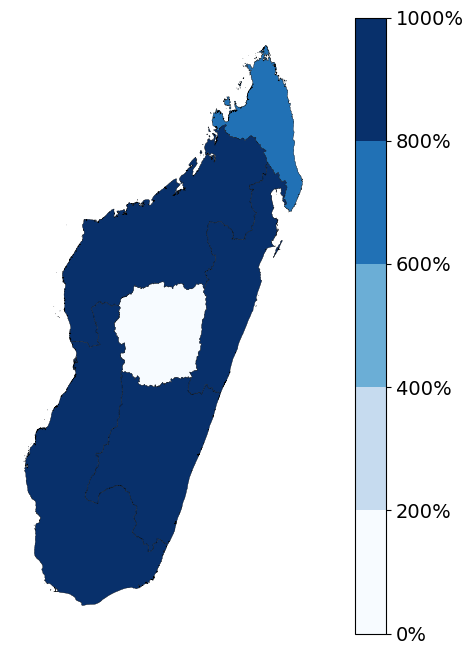

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('Blues', 5)
gpd_df_rel_change.to_crs(robinson).plot(column='rel_change', ax=ax, legend=True,
                  vmin=0, vmax=10, cmap=cmap, edgecolor='black', linewidth=0.2)

cbar = ax.get_figure().get_axes()[1]
#cbar.set_yticks([0, 3000, 6000, 9000, 12000, 15000])
cbar.tick_params(labelsize=fontsize)
# set cbar ticks as percentages
cbar.set_yticklabels([f'{int(i*100)}%' for i in cbar.get_yticks()])
# label title
#ax.set_title('Increase in AA displaced people', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+f'{ccode}_2100_optimistic_rel_change_in_AAD_vs_hist_CF.png', transparent=True)


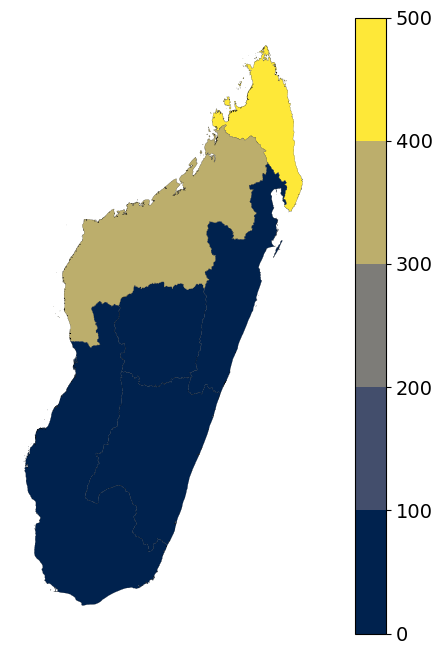

In [22]:

fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('cividis', 5)
gpd_df_cntry_hist_rp250.to_crs(robinson).plot(column='imp_rp_250.0_med', ax=ax, legend=True,
                  vmin=0, vmax=500, cmap=cmap, edgecolor='black', linewidth=0.1)
cbar = ax.get_figure().get_axes()[1]
#cbar.set_yticks([0, 10000, 20000, 30000, 40000, 50000])
cbar.tick_params(labelsize=fontsize)
# label title
#ax.set_title('Annual average displaced people - historical', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+f'{ccode}_hist_CF_RP250.png', transparent=True)

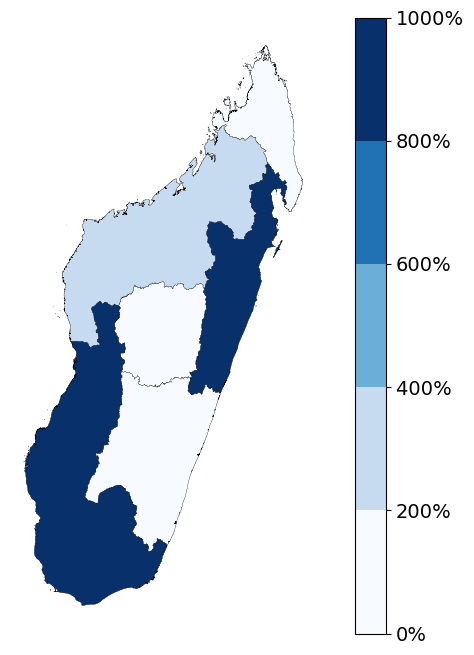

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('Blues', 5)
gpd_df_rel_change_rp250.to_crs(robinson).plot(column='rel_change', ax=ax, legend=True,
                  vmin=0, vmax=10, cmap=cmap, edgecolor='black', linewidth=0.2)

cbar = ax.get_figure().get_axes()[1]
#cbar.set_yticks([0, 3000, 6000, 9000, 12000, 15000])
cbar.tick_params(labelsize=fontsize)
# set cbar ticks as percentages
cbar.set_yticklabels([f'{int(i*100)}%' for i in cbar.get_yticks()])
# label title
#ax.set_title('Increase in AA displaced people', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+f'{ccode}_2100_optimistic_rel_change_in_RP250_vs_hist_CF.png', transparent=True)


## And the same for Japan


In [24]:
# load data for PHL
ccode = 'JPN'
cntry_admin1 = admin1_lookup[admin1_lookup['GID_0'] == ccode]
cname = cntry_admin1['COUNTRY'].values[0]

gpd_df_cntry = gpd.read_file(f'{shp_path}gadm41_{ccode}_shp/gadm41_{ccode}_1.shp')
gpd_df_cntry = gpd_df_cntry.merge(cntry_admin1[['fid', 'GID_1']], on='GID_1')

gpd_df_cntry_hist = prep_gpd_df_values(gpd_df_cntry, ccode, tc_risk_path,
                                rcp='245', thresh='0.55', rp='AAD', year='hist')
gpd_df_cntry_2100_245 = prep_gpd_df_values(gpd_df_cntry, ccode, tc_risk_path,
                                rcp='245', thresh='0.55', rp='AAD', year='2100')
gpd_df_cntry_hist_rp250 = prep_gpd_df_values(gpd_df_cntry, ccode, tc_risk_path,
                                rcp='245', thresh='0.55', rp='RP_250', year='hist')
gpd_df_cntry_2100_245_rp250 = prep_gpd_df_values(gpd_df_cntry, ccode, tc_risk_path,
                                rcp='245', thresh='0.55', rp='RP_250', year='2100')


# calc rel change
gpd_df_rel_change = gpd_df_cntry_2100_245.copy()
gpd_df_rel_change['rel_change'] = (gpd_df_cntry_2100_245['AAD_245_2100'] - gpd_df_cntry_hist['AAD_245_hist']) / gpd_df_cntry_hist['AAD_245_hist']
gpd_df_rel_change['rel_change'] = gpd_df_rel_change['rel_change'].replace(np.inf, 10)
gpd_df_rel_change['rel_change'] = gpd_df_rel_change['rel_change'].replace(np.nan, 0)

gpd_df_rel_change_rp250 = gpd_df_cntry_hist_rp250.copy()
gpd_df_rel_change_rp250['rel_change'] = (gpd_df_cntry_2100_245_rp250['RP_250_245_2100'] - gpd_df_cntry_hist_rp250['RP_250_245_hist']) / gpd_df_cntry_hist_rp250['RP_250_245_hist']
gpd_df_rel_change_rp250['rel_change'] = gpd_df_rel_change_rp250['rel_change'].replace(np.inf, 100)
gpd_df_rel_change_rp250['rel_change'] = gpd_df_rel_change_rp250['rel_change'].replace(np.nan, 0)

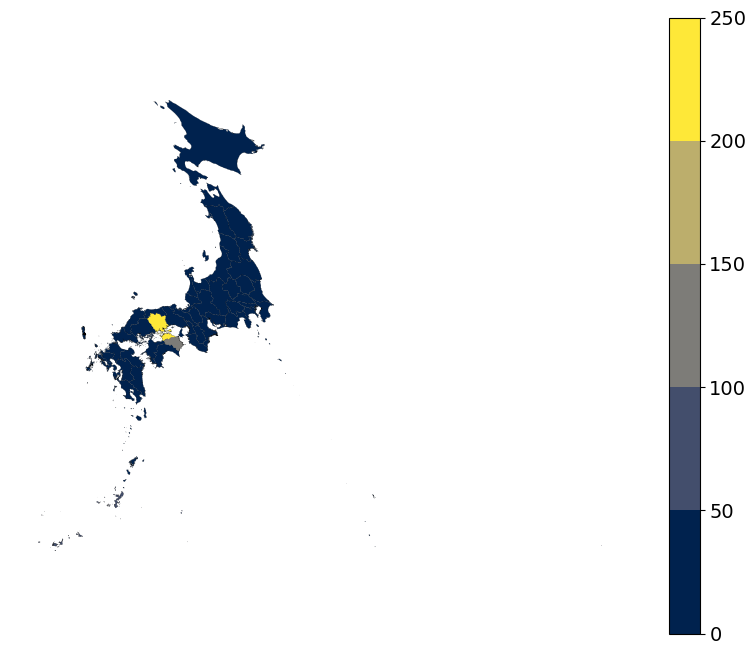

In [29]:
# Plot hist AAD
fontsize = 14
fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('cividis', 5)
gpd_df_cntry_hist.to_crs(robinson).plot(column='AAD_245_hist', ax=ax, legend=True,
                  vmin=0, vmax=250, cmap=cmap, edgecolor='black', linewidth=0.1)
cbar = ax.get_figure().get_axes()[1]
#cbar.set_yticks([0, 2000, 4000, 6000, 8000, 10000])
cbar.tick_params(labelsize=fontsize)
# label title
#ax.set_title('Annual average displaced people - historical', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+f'{ccode}_hist_TC_AAD.png', transparent=True)

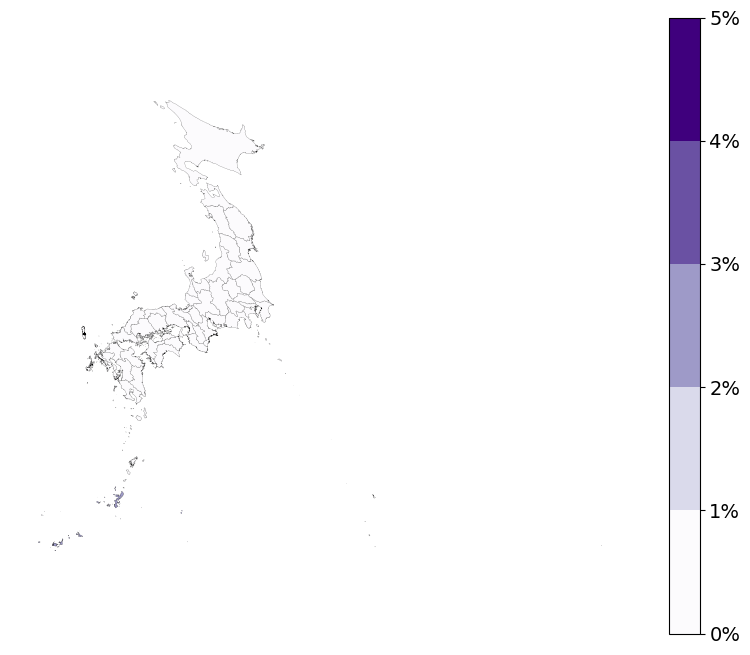

In [35]:
fontsize = 14
fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('Purples', 5)
gpd_df_rel_change.to_crs(robinson).plot(column='rel_change', ax=ax, legend=True,
                  vmin=0, vmax=0.05, cmap=cmap, edgecolor='black', linewidth=0.1)

cbar = ax.get_figure().get_axes()[1]
#cbar.set_yticks([0, 3000, 6000, 9000, 12000, 15000])
cbar.tick_params(labelsize=fontsize)
# set cbar ticks as percentages
cbar.set_yticklabels([f'{int(i*100)}%' for i in cbar.get_yticks()])
# label title
#ax.set_title('Increase in AA displaced people', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+f'{ccode}_2100_optimistic_rel_change_in_AAD_vs_hist_TC.png', transparent=True)


In [34]:
gpd_df_rel_change.rel_change.max()

0.029061637861864834

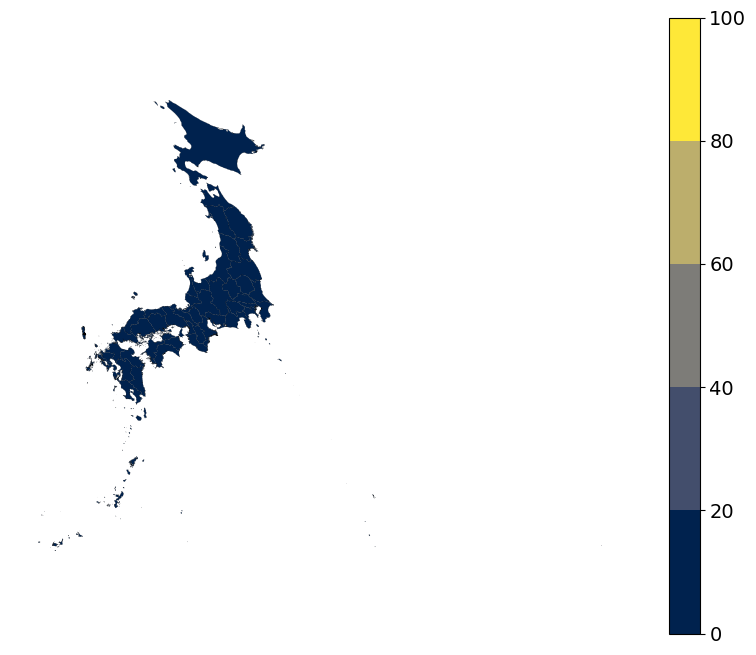

In [39]:
# Plot hist AAD
fontsize = 14
fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('cividis', 5)
gpd_df_cntry_hist_rp250.to_crs(robinson).plot(column='RP_250_245_hist', ax=ax, legend=True,
                  vmin=0, vmax=100, cmap=cmap, edgecolor='black', linewidth=0.1)
cbar = ax.get_figure().get_axes()[1]
#cbar.set_yticks([0, 2000, 4000, 6000, 8000, 10000])
cbar.tick_params(labelsize=fontsize)
# label title
#ax.set_title('Annual average displaced people - historical', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+f'{ccode}_hist_TC_RP250.png', transparent=True)

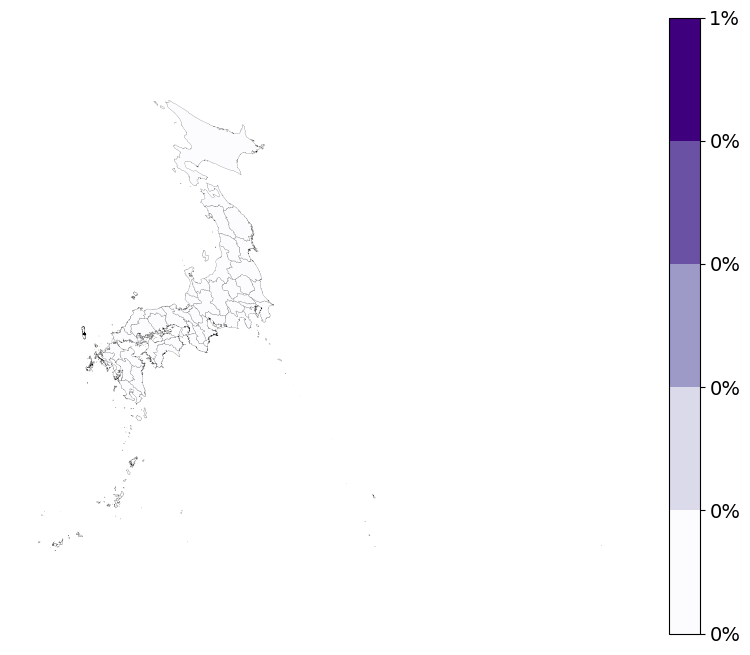

In [41]:
fontsize = 14
fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('Purples', 5)
gpd_df_rel_change_rp250.to_crs(robinson).plot(column='rel_change', ax=ax, legend=True,
                  vmin=0, vmax=0.01, cmap=cmap, edgecolor='black', linewidth=0.1)

cbar = ax.get_figure().get_axes()[1]
#cbar.set_yticks([0, 3000, 6000, 9000, 12000, 15000])
cbar.tick_params(labelsize=fontsize)
# set cbar ticks as percentages
cbar.set_yticklabels([f'{int(i*100)}%' for i in cbar.get_yticks()])
# label title
#ax.set_title('Increase in AA displaced people', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+f'{ccode}_2100_optimistic_rel_change_in_RP250_vs_hist_TC.png', transparent=True)


## same for CF Japan

In [65]:
ccode = 'JPN'
cntry_admin1 = admin1_lookup[admin1_lookup['GID_0'] == ccode]
cname = cntry_admin1['COUNTRY'].values[0]

gpd_df_cntry = gpd.read_file(f'{shp_path}gadm41_{ccode}_shp/gadm41_{ccode}_1.shp')
gpd_df_cntry = gpd_df_cntry.merge(cntry_admin1[['fid', 'GID_1']], on='GID_1')


gpd_df_cntry_hist = cf_prep_gpd_df_values(gpd_df_cntry, ccode, cf_risk_path,
                                rcp='RCP26', thresh='med', rp='aed', year='2020')
gpd_df_cntry_2100_245 = cf_prep_gpd_df_values(gpd_df_cntry, ccode, cf_risk_path,
                                rcp='RCP26', thresh='med', rp='aed', year='2100')
gpd_df_cntry_hist_rp250 = cf_prep_gpd_df_values(gpd_df_cntry, ccode, cf_risk_path,
                                rcp='RCP26', thresh='med', rp='imp_rp_250.0', year='2020')
gpd_df_cntry_2100_245_rp250 = cf_prep_gpd_df_values(gpd_df_cntry, ccode, cf_risk_path,
                                rcp='RCP26', thresh='med', rp='imp_rp_250.0', year='2100')


# calc rel change
gpd_df_rel_change = gpd_df_cntry_2100_245.copy()
gpd_df_rel_change['rel_change'] = (gpd_df_cntry_2100_245['aed_med'] - gpd_df_cntry_hist['aed_med']) / gpd_df_cntry_hist['aed_med']
gpd_df_rel_change['rel_change'] = gpd_df_rel_change['rel_change'].replace(np.inf, 10)
gpd_df_rel_change['rel_change'] = gpd_df_rel_change['rel_change'].replace(np.nan, 0)

gpd_df_rel_change_rp250 = gpd_df_cntry_2100_245_rp250.copy()
gpd_df_rel_change_rp250['rel_change'] = (gpd_df_cntry_2100_245_rp250['imp_rp_250.0_med'] - gpd_df_cntry_hist_rp250['imp_rp_250.0_med']) / gpd_df_cntry_hist_rp250['imp_rp_250.0_med']
gpd_df_rel_change_rp250['rel_change'] = gpd_df_rel_change_rp250['rel_change'].replace(np.inf, 100)
gpd_df_rel_change_rp250['rel_change'] = gpd_df_rel_change_rp250['rel_change'].replace(np.nan, 0)


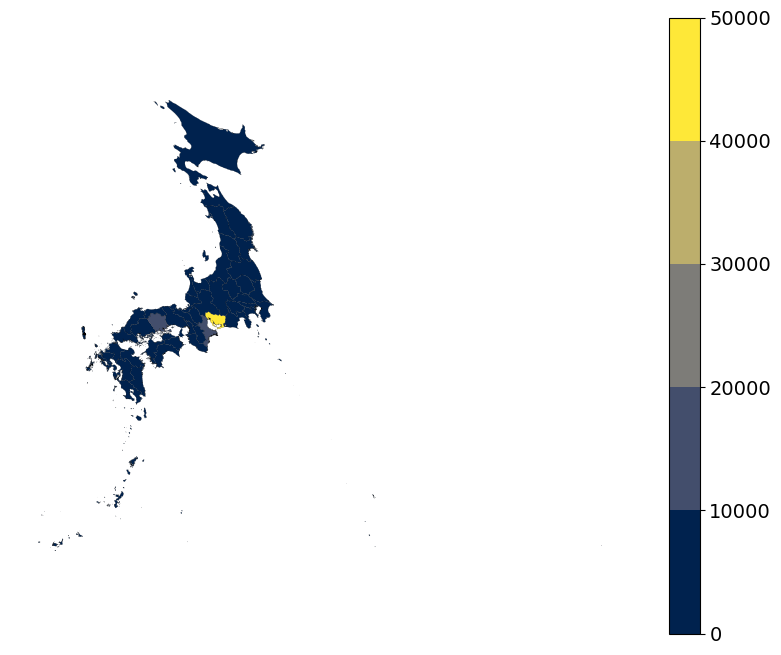

In [66]:

fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('cividis', 5)
gpd_df_cntry_hist.to_crs(robinson).plot(column='aed_med', ax=ax, legend=True,
                  vmin=0, vmax=50000, cmap=cmap, edgecolor='black', linewidth=0.1)
cbar = ax.get_figure().get_axes()[1]

cbar.tick_params(labelsize=fontsize)
# label title
#ax.set_title('Annual average displaced people - historical', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+f'{ccode}_hist_CF_AAD.png', transparent=True)

In [76]:
gpd_df_cntry_hist.aed_med.sum()

261603.84756358617

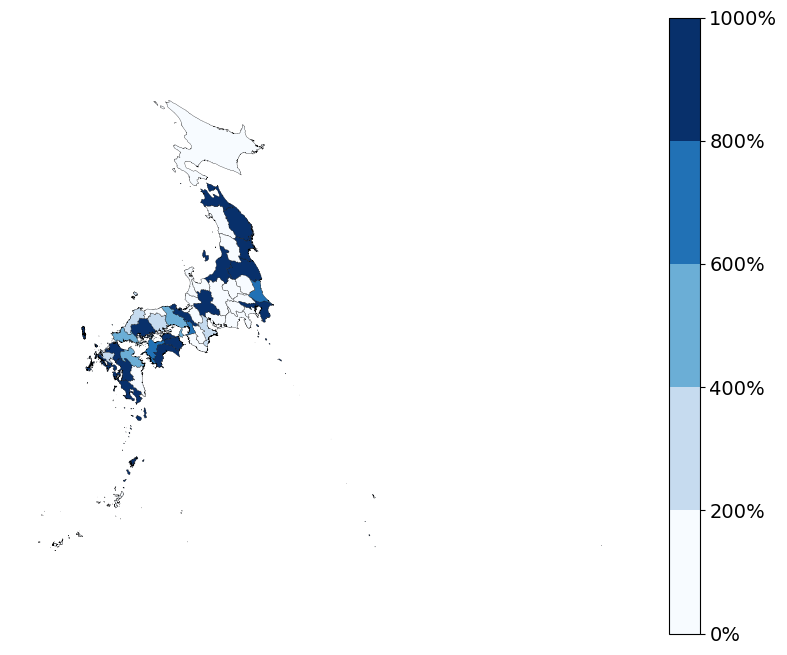

In [67]:
fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('Blues', 5)
gpd_df_rel_change.to_crs(robinson).plot(column='rel_change', ax=ax, legend=True,
                  vmin=0, vmax=10, cmap=cmap, edgecolor='black', linewidth=0.2)

cbar = ax.get_figure().get_axes()[1]
#cbar.set_yticks([0, 3000, 6000, 9000, 12000, 15000])
cbar.tick_params(labelsize=fontsize)
# set cbar ticks as percentages
cbar.set_yticklabels([f'{int(i*100)}%' for i in cbar.get_yticks()])
# label title
#ax.set_title('Increase in AA displaced people', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+f'{ccode}_2100_optimistic_rel_change_in_AAD_vs_hist_CF.png', transparent=True)


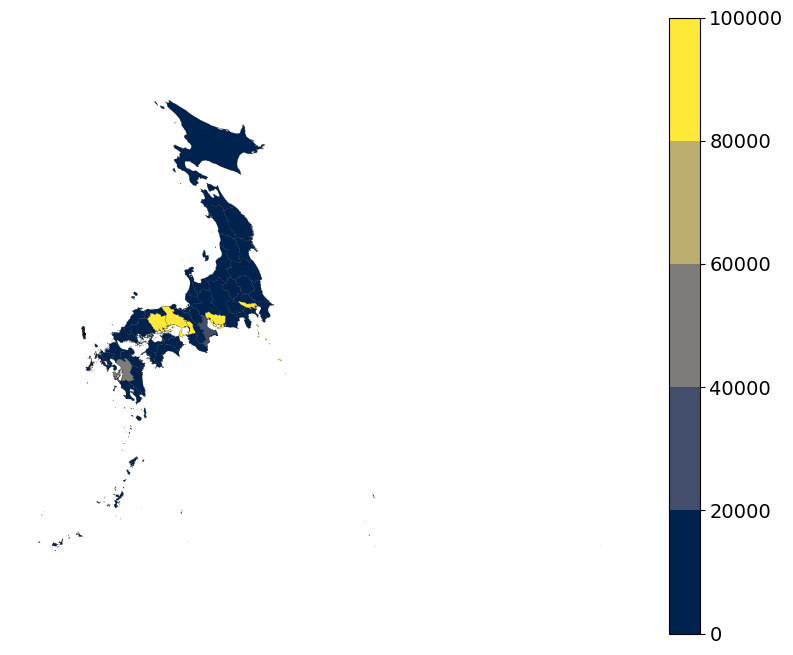

In [72]:

fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('cividis', 5)
gpd_df_cntry_hist_rp250.to_crs(robinson).plot(column='imp_rp_250.0_med', ax=ax, legend=True,
                  vmin=0, vmax=100000, cmap=cmap, edgecolor='black', linewidth=0.1)
cbar = ax.get_figure().get_axes()[1]
#cbar.set_yticks([0, 10000, 20000, 30000, 40000, 50000])
cbar.tick_params(labelsize=fontsize)
# label title
#ax.set_title('Annual average displaced people - historical', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+f'{ccode}_hist_CF_RP250.png', transparent=True)

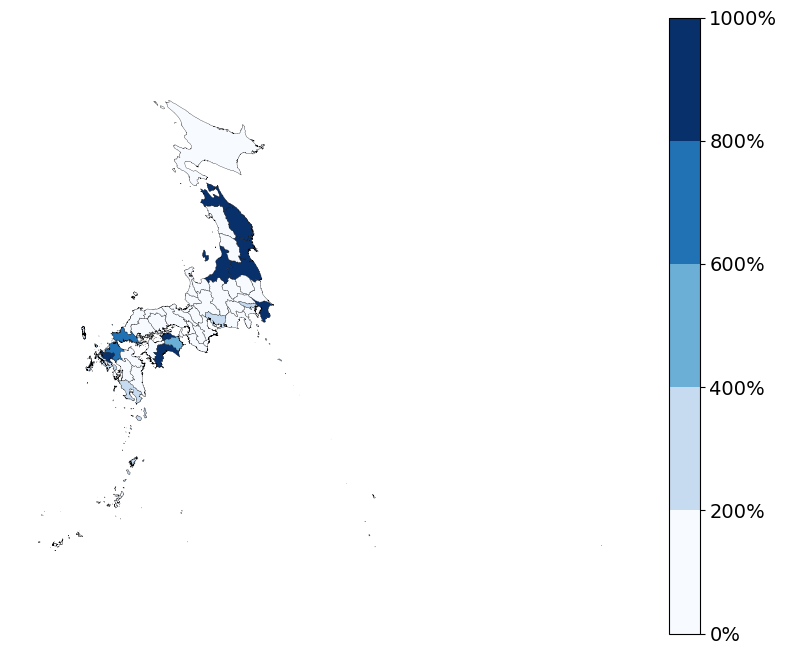

In [73]:
fig, ax = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.get_cmap('Blues', 5)
gpd_df_rel_change_rp250.to_crs(robinson).plot(column='rel_change', ax=ax, legend=True,
                  vmin=0, vmax=10, cmap=cmap, edgecolor='black', linewidth=0.2)

cbar = ax.get_figure().get_axes()[1]
#cbar.set_yticks([0, 3000, 6000, 9000, 12000, 15000])
cbar.tick_params(labelsize=fontsize)
# set cbar ticks as percentages
cbar.set_yticklabels([f'{int(i*100)}%' for i in cbar.get_yticks()])
# label title
#ax.set_title('Increase in AA displaced people', fontsize=fontsize)
sns.despine(left=True, bottom=True)
# drop x and y axis
ax.set_axis_off()
plt.savefig(fig_save_path+f'{ccode}_2100_optimistic_rel_change_in_RP250_vs_hist_CF.png', transparent=True)